# GCNNによる隣接行列の分類

## ライブラリのインポート，変数の設定

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import time
import datetime
from scipy.io import mmread
import random
import networkx as nx
import math
import os
import os.path as osp
from natsort import natsorted

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.transforms import Compose
from torch_scatter import  scatter

# random seed
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [2]:
test_run = True
add_noise = True

if test_run:
    # プログラムが動くかどうかのテスト用の小さいデータ
    train_root = osp.join("small_data_class","train")
    val_root = osp.join("small_data_class","val")
    test_root = osp.join("small_data_class","test")
    
    epoch_num = 3
    batch_size = 128
else:
    # 本番用データ   
    train_root = osp.join("data_class","train")
    val_root = osp.join("data_class","val")
    test_root = osp.join("data_class","test")    
    
    epoch_num = 100
    batch_size = 128

## データの用意

In [14]:
class EdgeAttrInvert():
    r"""raise edge_attr to the power p"""
    def __init__(self,p=-1.0):
        self.p = p
        
    def __call__(self, data):
        data.edge_attr = data.edge_attr**self.p
        return data

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

    
class MyOwnDataset(Dataset):
    
    processed_file_name = 'data_{}.pt'
    
    def __init__(self, root, transform=None, pre_transform=None):
        super(MyOwnDataset, self).__init__(root, transform, pre_transform)

    @property
    def processed_file_names(self):
        num_graph = len(os.listdir(osp.join(self.raw_dir,"adjs")))
        return [self.processed_file_name.format(i) for i in range(num_graph)]

    def process(self):
        adj_file_names = natsorted(os.listdir(osp.join(self.raw_dir,"adjs")))
        class_file_names = natsorted(os.listdir(osp.join(self.raw_dir,"classes")))
        
        for i, (adj_file_name,class_file_name) in enumerate(zip(adj_file_names,class_file_names)):
            adj_coo = mmread(osp.join(self.raw_dir, "adjs", adj_file_name))
            #class_id = mmread(osp.join(self.raw_dir, "classes", class_file_name)).toarray()[0,0]
            class_id = mmread(osp.join(self.raw_dir, "classes", class_file_name))[0,0]
            
            num_beads = adj_coo.shape[0]
            num_edges = adj_coo.nnz
            nnf = 1  ## nnf: num_node_features
            
            data = Data(
                x=torch.ones((num_beads, nnf)).float(),
                edge_index=torch.tensor([adj_coo.row, adj_coo.col], dtype=torch.long),
                edge_attr=torch.tensor(adj_coo.data.reshape(num_edges, -1)).float(),
                y=torch.tensor(class_id, dtype=torch.long)
            )
                        
            
            if self.pre_filter is not None and not self.pre_filter(data):
                continue

            if self.pre_transform is not None:
                data = self.pre_transform(data)
            
            
            torch.save(data, osp.join(self.processed_dir, self.processed_file_name.format(i)))

        
    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, 'data_{}.pt'.format(idx)))
        return data

In [15]:
eai = EdgeAttrInvert(p=-1.0)
my_transform = Compose([eai])

train_set = MyOwnDataset(train_root,transform=my_transform)
val_set = MyOwnDataset(val_root,transform=my_transform)
test_set = MyOwnDataset(test_root,transform=my_transform)

train_loader = DataLoader(train_set, batch_size=batch_size)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

Processing...
Done!
Processing...
Done!
Processing...
Done!


## ネットワークの定義

In [16]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #TODO: 入力グラフのチャネル数への依存をなくす
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 48)
        self.conv4 = GCNConv(48, 64)
        self.conv5 = GCNConv(64, 96)
        self.conv6 = GCNConv(96, 128)
        self.linear1 = torch.nn.Linear(128,64)
        #TODO: 分類数への依存をなくす
        self.linear2 = torch.nn.Linear(64,9)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        #edge_weightとして用いるedge_attrのshapeが(n,1)だとうまくいかない．
        #edge_attr.shapeが(n,)だと動く．おそらくPyG側のバグ？
        #edge_weight = data.edge_attr
        edge_weight = torch.squeeze(data.edge_attr)
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv3(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv4(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv5(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv6(x, edge_index, edge_weight)
        x = F.relu(x)

        x = scatter(x, data.batch, dim=0, reduce="max")
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

## 学習

In [17]:
start = time.time()

# GPUの使用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

train_size = len(train_set)
val_size = len(val_set)
test_size = len(test_set)

model = Net().to(device)

optimizer = torch.optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

model.train()
for epoch in range(epoch_num):
    train_correct = 0
    train_total = 0
    train_loss = 0.0
    for i, batch in enumerate(train_loader):
        batch = batch.to(device)
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch.y - 1)  ## 1th indexed -> 0th indexed
        loss.backward()
        optimizer.step()
        
        predicted = torch.max(outputs, 1)[1] + 1  ## 0th indexed -> 1th indexed
        train_total += batch.y.size(0)
        train_correct += (predicted == batch.y).sum().cpu().item()

        train_loss += loss.cpu().item()
        if i % 10 == 9:
            progress_bar = '['+('='*((i+1)//10))+(' '*((train_size//100-(i+1))//10))+']'
            print('\repoch: {:d} loss: {:.3f}  {}'
                .format(
                    epoch + 1,
                    loss.cpu().item(),
                    progress_bar),
                end="  ")

    train_acc = float(train_correct/train_total)

    print('\repoch: {:d} loss: {:.3f}'
        .format(epoch + 1, train_loss / (train_size / batch_size)), end="  ")
    history["train_acc"].append(train_acc)
    history["train_loss"].append(train_loss / (train_size / batch_size))

    correct = 0
    total = 0
    batch_num = 0
    loss = 0
    with torch.no_grad():
        model.eval()
        for data in val_loader:
            data = data.to(device)
            outputs = model(data)
            loss += criterion(outputs,data.y - 1)  ## 1th indexed -> 0th indexed
            predicted = torch.max(outputs, 1)[1] + 1  ## 0th indexed -> 1th indexed
            total += data.y.size(0)
            batch_num += 1
            correct += (predicted == data.y).sum().cpu().item()

    history["val_acc"].append(correct/total)
    history["val_loss"].append(loss.cpu().item()/batch_num)
    endstr = ' '*max(1,(train_size//1000-39))+"\n"
    print('Val Accuracy: {:.2f} %'.format(100 * float(correct/total)), end='  ')
    print(f'Val Loss: {loss.cpu().item()/batch_num:.3f}',end=endstr)

print('Finished Training')
elapsed_time = time.time() - start
print("elapsed time: {}".format(datetime.timedelta(seconds=int(elapsed_time))))


#テストデータでの最終結果出力
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for data in test_loader:
        data = data.to(device)
        outputs = model(data)
        predicted = torch.max(outputs, 1)[1] + 1  ## 0th indexed -> 1th indexed
        total += data.y.size(0)
        correct += (predicted == data.y).sum().cpu().item()
print('Test Accuracy: {:.2f} %'.format(100 * float(correct/total)))

device: cpu
epoch: 1 loss: 3.911  Val Accuracy: 11.11 %  Val Loss: 2.199 
epoch: 2 loss: 3.910  Val Accuracy: 11.11 %  Val Loss: 2.199 
epoch: 3 loss: 3.909  Val Accuracy: 11.11 %  Val Loss: 2.199 
Finished Training
elapsed time: 0:00:00
Test Accuracy: 11.11 %


## 可視化

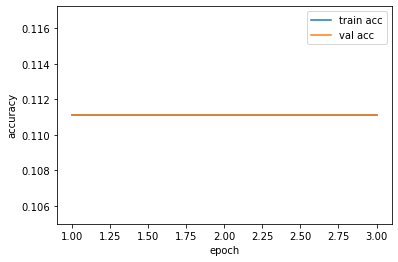

In [18]:
plt.xlabel("epoch")
plt.ylabel("accuracy")

x = np.arange(epoch_num) + 1
plt.plot(x, history["train_acc"], label="train acc")
plt.plot(x, history["val_acc"], label="val acc")
plt.legend()
plt.show()

## 実験条件

In [22]:
nBeads = train_set[0].num_nodes
n_train_smaples = len(train_set)
t = 20

print("=====Simulation conditions=====")
print("目的：隣接町列を生成した数字の予測")
print("ネットワーク：GCNN")
print("Test run: {}".format(test_run))
print("Number of beads: {}".format(nBeads))
print("Number of samples for training: {}".format(n_train_smaples))
print("Add noise: {}".format(add_noise))
print("Number of epochs: {}".format(epoch_num))
print("Batch size: {}".format(batch_size))
print("Diffusion time: {}".format(t))

print("=====Results=====")
print("elapsed time: {}".format(datetime.timedelta(seconds=int(elapsed_time))))
print('Test Accuracy: {:.2f} %'.format(100 * float(correct/total)))

=====Simulation conditions=====
目的：隣接町列を生成した数字の予測
ネットワーク：GCNN
Test run: True
Number of beads: 10
Number of samples for training: 72
Add noise: True
Number of epochs: 3
Batch size: 128
Diffusion time: 20
=====Results=====
elapsed time: 0:00:00
Test Accuracy: 11.11 %
